In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import itertools

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2
from analysis_functions import get_lassoCV
from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/1in3/muskegon/muskegon_absolute_otu_1in3.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/1in3/muskegon/muskegon_relative_otu_1in3.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/1in3/muskegon/muskegon_sampledata_1in3.tsv', sep= ' ', index_col=0, header=0)
productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', index_col=0, header=0)

In [3]:
'''Set sample names as index and shuffle data'''
index = target.Lake[target.Lake == 'Muskegon'].index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
productivity = productivity.loc[index,:]

#Shuffle data: 
#data_abs = data_abs.sample(frac=1, random_state=3)
#data_rel = data_rel.sample(frac=1, random_state=3)
#target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [4]:
hna_scores = pd.read_csv('Scores/hnascores_otus_1seq3_rel_Muskegon.csv', index_col=0)

''' Log-Ratio analyses '''
otus = list(data_rel.columns)
data_rel_repl = composition.multiplicative_replacement(data_rel.loc[:,otus])
data_rel_clr = pd.DataFrame(composition.clr(data_rel_repl), columns=otus, index=index)

In [5]:
tot_bacprod = productivity.loc[:,'tot_bacprod'].dropna()
index_prod = tot_bacprod[tot_bacprod.values < 90].index
prod = productivity.loc[index_prod,'tot_bacprod']

In [6]:
kendall_abs = np.zeros(hna_scores.shape[0])
p_kendall_abs = np.zeros(hna_scores.shape[0])
kendall_rel = np.zeros(hna_scores.shape[0])
p_kendall_rel = np.zeros(hna_scores.shape[0])
kendall_clr = np.zeros(hna_scores.shape[0])
p_kendall_clr = np.zeros(hna_scores.shape[0])

i=0
for otu in hna_scores.index:
    kendall_abs[i], p_kendall_abs[i] = kendalltau(data_abs.loc[index_prod,otu],prod)
    kendall_rel[i], p_kendall_rel[i] = kendalltau(data_rel.loc[index_prod,otu],prod)
    kendall_clr[i], p_kendall_clr[i] = kendalltau(data_rel_clr.loc[index_prod,otu],prod)
    i+=1
    
hna_scores['kendall_prod_abs'] = kendall_abs
hna_scores['p_kendall_prod_abs'] = p_kendall_abs
hna_scores['kendall_prod_rel'] = kendall_rel
hna_scores['p_kendall_prod_rel'] = p_kendall_rel
hna_scores['kendall_prod_clr'] = kendall_clr
hna_scores['p_kendall_prod_clr'] = p_kendall_clr

In [7]:
display(hna_scores.head(14))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,kendall,p_kendall,kendall_prod_abs,p_kendall_prod_abs,kendall_prod_rel,p_kendall_prod_rel,kendall_prod_clr,p_kendall_prod_clr
Otu000173,0.496,17982.674014,1.283752,0.002493,1.133719,0.554048,4.045914e-10,0.294737,0.069236,0.287250,0.079141,0.242105,0.135585
Otu000060,0.400,42735.699821,1.064030,0.005951,0.655716,0.458155,1.933086e-07,0.336842,0.037854,0.336030,0.040353,0.178947,0.269981
Otu000005,0.378,133132.588456,1.944657,0.015391,1.685016,0.249369,4.774608e-03,0.106966,0.514488,0.042786,0.794288,0.021053,0.896743
Otu004486,0.366,4.194974,7.874008,0.000003,7.874008,-0.179605,8.831829e-02,NaN,NaN,NaN,NaN,-0.242105,0.135585
Otu000905,0.366,1814.305844,1.643756,0.000255,1.338468,0.190119,4.954756e-02,0.356887,0.030745,0.329526,0.059731,0.263158,0.104757
Otu003366,0.352,254.514326,3.213090,0.000034,3.213496,0.374414,3.216754e-04,0.216366,0.259640,0.216366,0.259640,-0.105263,0.516412
Otu000242,0.284,4637.702315,1.343779,0.000707,1.073955,0.145186,1.138969e-01,0.149752,0.361446,0.111943,0.509498,0.063158,0.697031
Otu000075,0.278,27990.945263,1.060735,0.005448,1.315596,-0.267036,2.369199e-03,-0.284211,0.079775,-0.429722,0.008485,-0.463158,0.004302
Otu000696,0.272,281.956580,2.447397,0.000045,2.463390,0.279796,6.961777e-03,0.107341,0.571513,0.107341,0.571513,-0.136842,0.398920
Otu000539,0.270,1412.369629,1.699653,0.000248,1.455967,-0.274033,4.887314e-03,-0.031220,0.858364,-0.083037,0.640806,-0.178947,0.269981


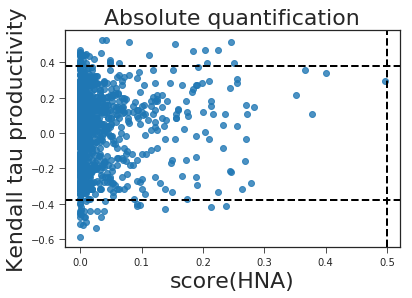

In [8]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_abs'], fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Absolute quantification', size=22)
plt.show()

In [9]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_abs'] > 0.377)].index

In [10]:
palette = itertools.cycle(sns.color_palette())
for otu in otus_prod: 
    plt.figure()
    sns.regplot(x=data_abs.loc[index_prod,otu],y=prod,label=otu, color=next(palette), fit_reg=True)
    plt.xlabel('Absolute abundance', size=22)
    plt.xticks(size=10)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=10)
    plt.legend()
    plt.show()
    i+=1

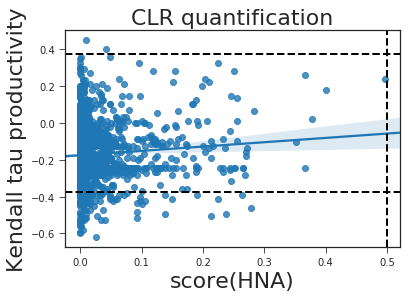

In [11]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_clr'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('CLR quantification', size=22)
plt.show()

In [12]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_clr'] > 0.377)].index
palette = itertools.cycle(sns.color_palette())
for otu in otus_prod: 
    plt.figure()
    sns.regplot(x=data_rel.loc[index_prod,otu],y=prod,label=otu, color=next(palette), fit_reg=True)
    plt.xlabel('Relative abundance', size=22)
    plt.xticks(size=10)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=10)
    plt.legend()
    plt.show()
    i+=1

In [13]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_rel'] > 0.377)].index

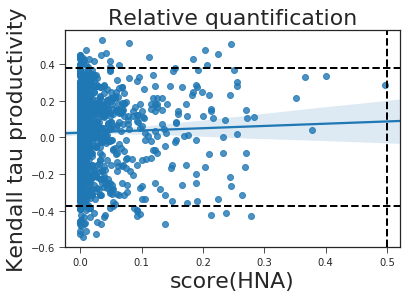

In [14]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_rel'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Relative quantification', size=22)
plt.show()

In [15]:
kendall_sum_abs = np.zeros(hna_scores.shape[0])
p_kendall_sum_abs = np.zeros(hna_scores.shape[0])
kendall_sum_rel = np.zeros(hna_scores.shape[0])
p_kendall_sum_rel = np.zeros(hna_scores.shape[0])
kendall_sum_clr = np.zeros(hna_scores.shape[0])
p_kendall_sum_clr = np.zeros(hna_scores.shape[0])
kendall_sum_rel_thr = np.zeros(hna_scores.shape[0])
p_kendall_sum_rel_thr = np.zeros(hna_scores.shape[0])

sum_abs = np.zeros(len(index_prod))
sum_rel = np.zeros(len(index_prod))
sum_clr = np.zeros(len(index_prod))
sum_rel_thr = np.zeros(len(index_prod))

i=0
thr = 0
for otu in hna_scores.index:
    sum_abs += data_abs.loc[index_prod,otu]
    sum_rel += data_rel.loc[index_prod,otu]
    sum_clr += data_rel_clr.loc[index_prod,otu]
    sum_rel_thr += data_rel.loc[index_prod,otu]
    kendall_sum_abs[i], p_kendall_sum_abs[i] = kendalltau(sum_abs,prod)
    kendall_sum_rel[i], p_kendall_sum_rel[i] = kendalltau(sum_rel,prod)
    kendall_sum_clr[i], p_kendall_sum_clr[i] = kendalltau(sum_clr,prod)
    kendall_sum_rel_thr[i], p_kendall_sum_rel_thr[i] = kendalltau(sum_rel_thr,prod)
    if kendall_sum_rel_thr[i] > thr: 
        thr = kendall_sum_rel_thr[i]
    else: 
        sum_rel_thr -= data_rel.loc[index_prod,otu]
        kendall_sum_rel_thr[i] = 0
    i+=1

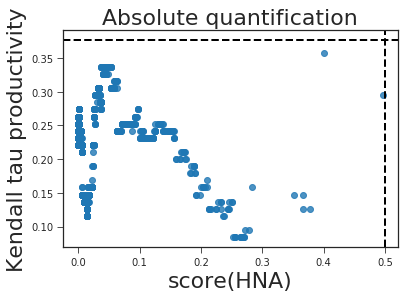

In [16]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_abs,fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Absolute quantification', size=22)
plt.show()

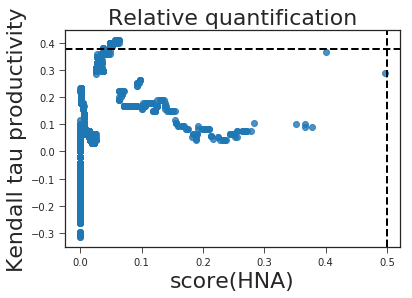

In [17]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_rel, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Relative quantification', size=22)
plt.show()

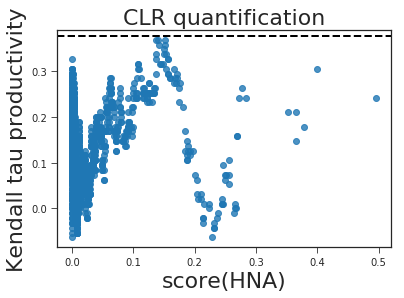

In [18]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_clr, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('CLR quantification', size=22)
plt.show()

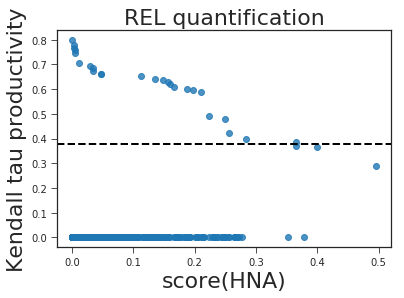

In [23]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_rel_thr, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('REL quantification', size=22)
plt.show()

In [22]:
otus_prod = hna_scores.loc[kendall_sum_rel_thr > 0,:].index
print('OTUs part of productivity correlation pool:' + str(otus_prod))

OTUs part of productivity correlation pool:Index(['Otu000173', 'Otu000060', 'Otu004486', 'Otu000905', 'Otu000242',
       'Otu000221', 'Otu000175', 'Otu000614', 'Otu000067', 'Otu000778',
       'Otu000917', 'Otu000409', 'Otu000639', 'Otu003780', 'Otu000799',
       'Otu000390', 'Otu000647', 'Otu000894', 'Otu000594', 'Otu000246',
       'Otu002620', 'Otu001180', 'Otu000202', 'Otu000117', 'Otu000273',
       'Otu009204', 'Otu000821', 'Otu000094'],
      dtype='object')


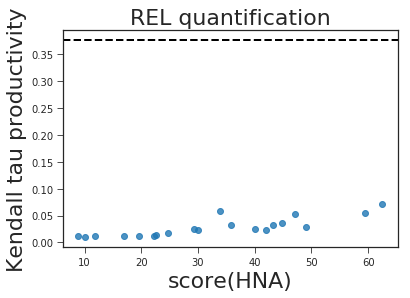

In [24]:
plt.figure()
sns.regplot(x=prod,y=sum_rel_thr, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('REL quantification', size=22)
plt.show()